In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
def connect_graph(G,v, **kwargs):
    """connects a graph. All edges will be length 1 between connected component
    graph and point locaitons (for triangle inequality) as input
    
    returns a graph 
    """
    adjmat = nx.to_numpy_matrix(G)
    concomp = nx.algorithms.components.connected_components(G)
    choices = []
    for comp in concomp:
        choices.append(np.random.choice(list(comp), 1, replace = False)[0])
    choices = np.array(choices)
    import itertools
    indecies = np.array(list(itertools.product(choices, choices)))
    setter = []
    for index in indecies:
        if index[0] == index[1]:
            setter.append(False)
        else:
            setter.append(True)
    indecies = indecies[setter]
    for index in indecies:
        adjmat[index[0], index[1]] = np.linalg.norm(v[index[0]] - v[index[1]])
        adjmat[index[1], index[0]] = np.linalg.norm(v[index[0]] - v[index[1]])
        
    return nx.from_numpy_matrix(adjmat)

In [3]:
def check_triangle(G, **kwargs):
    spaths = nx.algorithms.shortest_paths.generic.shortest_path(G)
    nnodes = len(G._node)
    for i, row in enumerate(nx.to_numpy_array(G)):
        for j, w in enumerate(row):
            if w != 0:
                if len(spaths[i][j]) != 2:
                    return False
    return True

In [4]:
def connect_2clusters(graphs, vs, maxconnections = 1, verbosity = 0, **kwargs):
    """
    array like of of graphs
    array like of points in each graph
    maxconnections is how many connections between clusters
    """
    G1, G2 = graphs
    v1, v2 = vs
    a, b = nx.to_numpy_array(G1), nx.to_numpy_array(G2)
    anew = np.concatenate((a, np.zeros((a.shape[0], b.shape[0]), )),axis = 1)
    bnew = np.concatenate((np.zeros((b.shape[0], a.shape[0]),), b),axis = 1)
    out = np.concatenate((anew,bnew),axis = 0)
    concomplist = list(nx.algorithms.components.connected_components(nx.from_numpy_array(out)))
    if len(concomplist)!= 2:
        raise ValueError('trying to merge more than two graphs')
    ncon = np.random.randint(low = 1, high = maxconnections+1)
    choices_from_first = np.random.choice(list(concomplist[0]), ncon,)
    choices_from_second = np.random.choice(list(concomplist[1]), ncon) 
    for inds in zip(choices_from_first, choices_from_second):
        dist = np.linalg.norm(v1[inds[0]] - v2[inds[1]- len(concomplist[0])]) #to get the indexing correct for the points
        out[inds[0], inds[1]] = dist
        out[inds[1], inds[0]] = dist
    G = nx.from_numpy_array(out)
    if not check_triangle(G, **kwargs):
        raise ValueError('not satisfy triangle')
    if not nx.algorithms.components.connected.is_connected(G):
        raise ValueError('not connected')
    v = np.concatenate((v1, v2)) 
    if verbosity>1:
        print('generated ', ncon, ' connections between clusters')
    return G, v

In [5]:
def generate_cluster(nnodes, p, yrange=(0,1), xrange = (0,1), **kwargs):
    """returns a connected graph and location of points in space for generating a clustered graph
    
    nnodes - how many nodes in cluster
    p - probability of generating an edge between nodes
    """
    n = nnodes
    G = nx.fast_gnp_random_graph(n, p,)
    adjmat = nx.to_numpy_matrix(G)

    #generate random n random points:
    v = np.random.rand(n, 2)
    v[:,0] = (v[:,0] )*(xrange[1] - xrange[0]) + xrange[0]
    v[:,1] = (v[:,1] )*(yrange[1] - yrange[0]) + yrange[0]
    
    #check if connected
    G = connect_graph(G, v, **kwargs)
    adjmat = nx.to_numpy_matrix(G)
    
    
    tadjmat = adjmat.copy()
    for i, row in enumerate(adjmat):
        newrow = np.array([np.linalg.norm(v[i] - v[j]) for j in range(n)])*np.array(row)
        tadjmat[i] = newrow

    adjmat = tadjmat
    del tadjmat
    adjmat
    Gp = nx.from_numpy_matrix(adjmat)
    return Gp, v

In [6]:
G1, v1 = generate_cluster(10, .1,xrange = (5,10), yrange= (-1,1)) # one paramter is how dense each cluster is. we may do better if they are dense
G2, v2 = generate_cluster(20, .5,xrange = (0,2), yrange= (9,15))

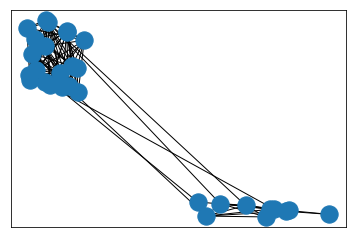

In [7]:
G, v = connect_2clusters((G1, G2), (v1, v2),maxconnections=5,)
pos = dict()
for i, vi in enumerate(v):
    pos.update({i:vi})
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

## I don't really think it is fruitful to right a complete function, but it can be done easy

In [511]:
def generate_clustered_graph(k, nnodes = 10,**kwargs):
    """
    k - how many clusters
    nnodes - int . how many nodes total
    """
    nodes_per_cluster = []
    
    return G, v

In [566]:
k, nnodes = 5, 15
nper = []
for i, worker in enumerate(np.sort(np.random.choice(np.linspace(1,nnodes,nnodes), k-1, replace = False))):
    if i == 0:
        last = 0
    nper.append(int(worker - last))
    last = worker
nper.append(int(nnodes - last))
nper #how many nodes per cluster


[3, 3, 1, 4, 4]

## Now lets generate a real graph of size 100 and 5 clusters

In [667]:
G1, v1 = generate_cluster(20, .1,xrange = (5,10), yrange= (-1,1)) 
G2, v2 = generate_cluster(20, .1,xrange = (0,2), yrange= (9,15))
G3, v3 = generate_cluster(20, .1,xrange = (-17,-16), yrange= (-12,-11))
G4, v4 = generate_cluster(20, .1,xrange = (32,45), yrange= (9,15))
G5, v5 = generate_cluster(20, .1,xrange = (10,18), yrange= (16,21))

In [672]:
G, v = connect_2clusters((G1, G2), (v1, v2), maxconnections = 5)

for gi, vi in zip([G3, G4, G5], [v3, v4, v5]):
    G, v = connect_2clusters((G, gi), (v, vi), maxconnections = 5)

In [ ]:
G = nx.readwrite.gpickle.read_gpickle('./graphstore/tempG.pkl')


dropoff nodes:  [16 25 59 78 83]


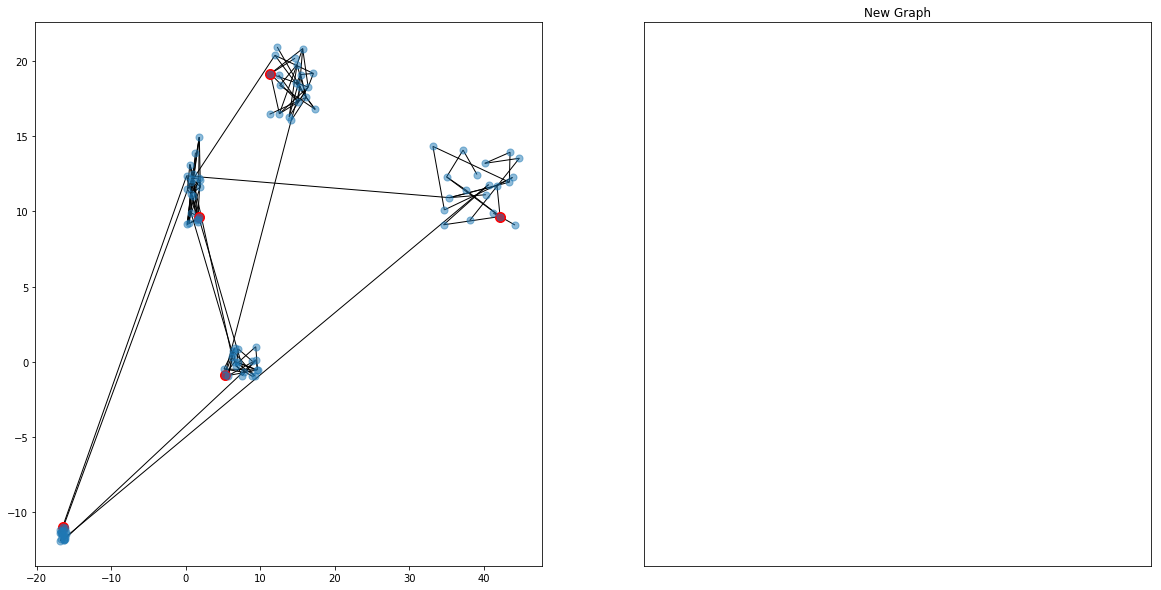

In [673]:
fig, axs = plt.subplots(ncols = 2, figsize = (20,10))

ax = axs[0]

pos = dict()
for i, vi in enumerate(v):
    pos.update({i:vi})
nx.draw_networkx_nodes(G, pos, ax = ax, alpha = .5, node_size = 50)
nx.draw_networkx_edges(G, pos, ax = ax)

#generate drop off points (one in each cluster)
dropoffs = np.array([np.random.randint(20) for i in range(5)]) + np.array([0,20,40,60,80])#20 points per cluster
dropoff_pts = v[dropoffs]
ax.scatter(dropoff_pts[:,0],dropoff_pts[:,1], color = 'red', s = 100)
print('dropoff nodes: ', dropoffs)
axs[1].set_title('New Graph')
s = dropoffs[0]
d1, d2, d3, d4 = np.array(dropoffs)[1:]

In [677]:
nx.readwrite.gpickle.write_gpickle(G, './graphstore/tempG.pkl')

In [686]:
import pickle
with open('./graphstore/dropoffnodes.pkl', 'wb') as f:
    pickle.dump(dropoffs, f)

In [666]:
spaths = nx.shortest_path(G,)
spaths[dropoffs[0]][dropoffs[1]]

[2, 0, 17, 1, 3, 11, 10, 35, 34, 39, 27]

In [ ]:
def generate_new_graph(G, )

In [659]:
newG = nx.Graph()

In [660]:
newG.add_nodes_from(dropoffs)

In [661]:
newG._node

{12: {}, 29: {}, 52: {}, 68: {}, 99: {}}

In [675]:
nx.to_numpy_matrix(G)

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [676]:
nx.algorithms.components.connected.is_connected(G)

True

Clusters of graphs connect them

Tree and then add edges

Purely Random